In [1]:
import numpy as np
import pandas as pd

from sktime.forecasting.arima import ARIMA, AutoARIMA
# from sktime.forecasting.arima import StatsModelsARIMA
# from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.utils.plotting import plot_series
# временной горизонт для прогнозирования
from sktime.forecasting.base import ForecastingHorizon

import pandas_datareader.data as web

# тесты диагностики
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать ValueWarning, ConvergenceWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning
warnings.simplefilter('ignore', category=ValueWarning)
warnings.simplefilter('ignore', category=ConvergenceWarning)

In [2]:
y = np.log(web.DataReader(name='M2SL', data_source='fred', start='1995-01-01'))
y.index = y.index.to_period(freq='M') # замена индекса на периодический. Иначе кросс-валидация не будет работать
# длина ряда
len(y)

361

In [19]:
# Общий подход к оценке оптимальной модели ARIMA
forecaster = AutoARIMA(information_criterion='aic', test='kpss', seasonal=False, max_p=10, max_q=10)
forecaster.fit(y)
forecaster.get_fitted_params() #['order']

{'intercept': 0.0019404499468918593,
 'ar.L1': 0.611558223943569,
 'sigma2': 1.9712747511002272e-05,
 'order': (1, 1, 0),
 'seasonal_order': (0, 0, 0, 0),
 'aic': -2871.768955342817,
 'aicc': -2871.7015396124802,
 'bic': -2860.1106432484667,
 'hqic': -2867.133389398556}

# Тест единичного корня
Пытаемся ответить на вопрос "Стационарность или не стационарность???"

In [5]:
import numpy as np
import pandas as pd

from sktime.param_est.stationarity import StationarityADF, StationarityKPSS, StationarityDFGLS, \
	StationarityPhillipsPerron, StationarityADFArch, StationarityKPSSArch

import pandas_datareader.data as web

# настройки визуализации
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать InterpolationWarning из statsmodels
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', category=InterpolationWarning)

In [6]:
y = np.log(web.DataReader(name='M2SL', data_source='fred', start='1995-01-01'))
y.index = y.index.to_period(freq='M') # замена индекса на периодический. Иначе кросс-валидация не будет работать
# длина ряда
len(y)

361

### ADF

In [ ]:
sty_est = StationarityADF(p_threshold=0.05, regression='ct', autolag='BIC')
sty_est.fit(y)
sty_est.get_fitted_params()

{'pvalue': 0.39690962302773836,
 'stationary': False,
 'test_statistic': -2.3677292402945285,
 'used_lag': 1}

In [ ]:
# c - т.к. тренд убивается
sty_est = StationarityADF(p_threshold=0.05, regression='c', autolag='BIC')
sty_est.fit(y.diff().dropna()) 
sty_est.get_fitted_params()

{'pvalue': 1.2229705173161054e-15,
 'stationary': True,
 'test_statistic': -9.28489115282,
 'used_lag': 0}

### KPSS

In [11]:
sty_est = StationarityKPSS(p_threshold=0.05, regression='ct')
sty_est.fit(y)
sty_est.get_fitted_params()

{'lags': 11,
 'pvalue': 0.021278753083525215,
 'stationary': False,
 'test_statistic': 0.18592332511059942}

In [12]:
sty_est = StationarityKPSS(p_threshold=0.05, regression='ct')
sty_est.fit(y.diff().dropna())
sty_est.get_fitted_params()

{'lags': 9,
 'pvalue': 0.1,
 'stationary': True,
 'test_statistic': 0.0606027030830028}

## Autocorrelation Tests

In [13]:
forecaster = ARIMA(order=(1,1,0), trend='c')
forecaster.fit(y)
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  361
Model:               SARIMAX(1, 1, 0)   Log Likelihood                1438.884
Date:                Tue, 25 Mar 2025   AIC                          -2871.769
Time:                        11:39:00   BIC                          -2860.111
Sample:                    01-31-1995   HQIC                         -2867.133
                         - 01-31-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0019      0.000      5.810      0.000       0.001       0.003
ar.L1          0.6116      0.016     37.571      0.000       0.580       0.643
sigma2      1.971e-05   5.09e-07     38.728      0.000    1.87e-05    2.07e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):              8121.21
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               2.36   Skew:                             2.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
# model_df = p+q
acorr_ljungbox(forecaster.predict_residuals(y).dropna() , lags=[5], model_df=2)

,lb_stat,lb_pvalue
5,10.400755,0.015449


In [ ]:
#### от автокорреляции можно избавиться, включив больше лагов в модель

# Heteroskedasticity test

In [17]:
lm_stat, lm_pval, f_stat, f_pval = het_arch(forecaster.predict_residuals(y).dropna(), nlags=7, ddof=2+2)

lm_stat, lm_pval

(73.677257048601, 2.6608627327732756e-13)

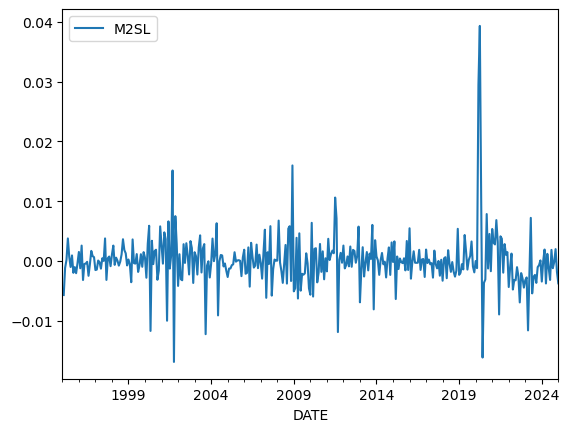

In [18]:
forecaster.predict_residuals(y).plot()
plt.show()

Для данного ряда модель ARIMA работает плохо. Нужно придумать к ней "костыли"

### ДЗ: номер 4 (диагностика - проверить на автокорелляцию и гетероскедастичность)